<a href="https://colab.research.google.com/github/raquelcarmo/tropical_cyclones/blob/import-py-files/src/code/TC_GradCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones
%ls

import imp 
# import helper.py
helper = imp.new_module('helper_functions')
exec(open("./helper_functions.py").read(), helper.__dict__)

In [ ]:
# getting in the directory 
%cd /content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
%ls

/content/drive/My Drive/ESRIN_PhiLab/Tropical_Cyclones/data
best_track/                            SAR_swath_images_VV+VH+WS/
categorisation.png                     SAR_swath_images_VV+VH+WS_old/
identification.png                     SAR_swath_images_WS+sWSO+cWSO/
model_comparisons_between_datasets/    SAR_swath_images_WS+sWSO+cWSO_old/
model.png                              SAR_swath_images_WS+WS+WS/
parametric_model/                      SAR_swath_images_WS+WS+WS_old/
SAR_IMAGE_DATASET_EYE_CLASSIFICATION@  SAR_swath_masks/
SAR_swath_images@                      SAR_swath_nc/
SAR_swath_images_VV+VH+VH/             SAR_swath_Vmax/
SAR_swath_images_VV+VH+VH_old/


In [ ]:
# general imports
import random
import glob
import os
import sys
sys.stdout.flush()
import pandas as pd
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import imageio
import os.path
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from google.colab.patches import cv2_imshow
import random
from shapely.geometry import Point
import re
import pickle
import scipy
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras import Input
from tensorflow.keras.applications import resnet50, mobilenet_v2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, TruePositives, FalsePositives, TrueNegatives, FalseNegatives
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.set_printoptions(precision=4)

In [ ]:
class DataProcessor():
  def __init__(self, model = "ResNet", min_height = 200, min_width = 200, normalise = True, rotate = False, 
               plot_light = False, plot_extensive = False, show_prints = False):

    self.model = model
    self.min_height = min_height
    self.min_width = min_width
    self.normalise = normalise
    self.rotate = rotate
    self.plot_light = plot_light
    self.plot_extensive = plot_extensive
    self.show_prints = show_prints
    self.img_name = None


  def preprocess_pipeline(self, image_path, bbox):
    ''' Defines the preprocess pipeline '''
    #image_path = image_path.numpy().decode('utf-8')
    #bbox = bbox.numpy()
    if self.show_prints:
      print("[START]: preprocess_pipeline")
      print(image_path, bbox)
    self.img_name = os.path.basename(image_path)[:-4]
    #filelist = glob.glob("SAR_swath_masks/" + image_path.split('/')[1] + '/' + self.img_name + "*.npy")
    #mask = np.load(filelist[0]) if filelist != [] else None

    # read the image path
    im = cv2.imread(image_path).astype(np.float32) # loads images as BGR in float32
    image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   # BGR -> RGB

    if self.plot_extensive:
      print("Before:", image.shape)
      cv2_imshow(image)

    if self.rotate:
      # perform rotation to the images
      image, bbox_rotated = self.rotation(image_path, bbox)
    else:
      # look for bounding box
      bbox_rotated = None if (bbox == 0).all() else bbox

    # perform padding and then cropping to the images
    padded_image, bbox_padded = self.padding(image, bbox_rotated)
    sized_image = self.random_crop(padded_image, bbox_padded)

    if self.normalise:
      # perform normalisation to the images
      #output_image = self.normalisation(output_image, z_norm = False)
      if self.model == "ResNet":
        norm_image = resnet50.preprocess_input(output_image)
      elif self.model == "Mobile":
        norm_image = mobilenet_v2.preprocess_input(output_image)
      else:
        sys.exit("Incert valid network model. Options: Mobile or ResNet (case sensitive)")
    else:
      norm_image = None
    # force land values to be zero
    #output_image[mask == 1] = 0

    if self.show_prints:
      print("[END]: preprocess_pipeline")
    # return output_image (not normalised) and normalised_output_image
    return tf.transpose(output_image, [1,0,2]), tf.transpose(norm_image, [1,0,2])


  def padding(self, image, bbox):
    '''Takes an input image and returns a padded version of it with
    the required dimensions to reach self.min_height, self.min_width'''
    h, w = image.shape[:2]
    if h >= self.min_height and w >= self.min_width:
      return image, bbox
      
    new_values = None
    h1 = (self.min_height - h)//2 if (self.min_height - h)//2 > 0 else 0
    w1 = (self.min_width - w)//2 if (self.min_width - w)//2 > 0 else 0
    padded_img = cv2.copyMakeBorder(image, 
                                    top = h1+1 if (self.min_height - (h+ 2*h1)) == 1 else h1, 
                                    bottom = h1, 
                                    left = w1+1 if (self.min_width - (w+ 2*w1)) == 1 else w1, 
                                    right = w1, 
                                    borderType = cv2.BORDER_CONSTANT,
                                    value = [0.0, 0.0, 0.0])
    if bbox is not None:
      x_left = (int)(bbox[0])
      y_top = (int)(bbox[1])
      bb_width = (int)(bbox[2]) 
      bb_height = (int)(bbox[3])

      # translate the x_left and y_top values according to the pad
      x_left += w1+1 if (self.min_width - (w+ 2*w1)) == 1 else w1
      y_top += h1+1 if (self.min_height - (h+ 2*h1)) == 1 else h1
      new_values = np.array([x_left, y_top, bb_width, bb_height])

    if self.plot_extensive:
      print("After padding:", padded_img.shape)
      cv2_imshow(padded_img)
    return padded_img, new_values


  def normalisation(self, image, z_norm = True, **kwargs):
    '''Takes an input image and returns a normalised version of it'''
    if z_norm:
      # values z transformation
      #im = image.astype('float')
      im[im == 0] = np.nan

      if np.isnan(im).all():
        #print("Problematic img: ", self.img_name, " shape:", im.shape)
        return image

      mean = np.nanmean(im)
      sd = np.nanstd(im)
      n_im = (im - mean) / sd
      n_im = np.nan_to_num(n_im)
    else:
      # values normalised between 0 and 1
      n_im = image/np.max(image)

    if self.plot_extensive:
      print('After normalising: range ' + str(round(np.nanmin(n_im), 3)) + ' to ' + str(round(np.nanmax(n_im), 3)))
      print(n_im.shape)
      cv2_imshow(n_im)
    return n_im


  def rotation(self, image_path, bbox):
    '''Takes an input image and returns a rotated version of it'''
    # read the image path
    im = cv2.imread(image_path) # loads image as BGR in uint8
    image = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   # BGR -> RGB
    h, w = image.shape[:2]
    new_values = None

    # convert to gray image
    img_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    # use threshold to find contours of relevant gray image
    ret, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_TRUNC)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]

    # rectangle detected around the relevant image
    rect = cv2.minAreaRect(cnt)   # rect = ((center_x,center_y), (width,height), angle)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # get width and height of the detected rectangle
    rect_width = int(rect[1][0])
    rect_height = int(rect[1][1])
    
    src_pts = box.astype("float32")
    if rect_height < rect_width:
      # coordinate of the points in box points after the rectangle has been straightened
      dst_pts = np.array([[rect_height-1, rect_width-1],
                          [0, rect_width-1],
                          [0, 0],
                          [rect_height-1, 0]], dtype="float32")
      
      # the perspective transformation matrix
      M = cv2.getPerspectiveTransform(src_pts, dst_pts)

      # directly warp the rotated rectangle to get the straightened rectangle
      warped = cv2.warpPerspective(image, M, (rect_height, rect_width))

    else:
      # coordinate of the points in box points after the rectangle has been straightened
      dst_pts = np.array([[0, rect_height-1],
                          [0, 0],
                          [rect_width-1, 0],
                          [rect_width-1, rect_height-1]], dtype="float32")

      # the perspective transformation matrix
      M = cv2.getPerspectiveTransform(src_pts, dst_pts)

      # directly warp the rotated rectangle to get the straightened rectangle
      warped = cv2.warpPerspective(image, M, (rect_width, rect_height))
    warped = warped.astype(np.float32)

    # look for bounding box
    if not (bbox == 0).all():
      # read dimensions of bbox_eye
      cX = (int)(bbox[0])
      cY = (int)(bbox[1])
      bb_width = (int)(bbox[2])
      bb_height = (int)(bbox[3])

      # recompute center of bbox according to transformation matrix
      new_cX = (M[0][0]*cX + M[0][1]*cY + M[0][2]) / ((M[2][0]*cX + M[2][1]*cY + M[2][2]))
      new_cY = (M[1][0]*cX + M[1][1]*cY + M[1][2]) / ((M[2][0]*cX + M[2][1]*cY + M[2][2]))
      new_values = np.array([new_cX, new_cY, bb_width, bb_height])

      if self.plot_extensive:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(image)
        ax1.add_patch(matplotlib.patches.Rectangle((cX, cY), bb_width, bb_height, color ='green', fc='none'))
        ax1.set(title = "Original image with bbox (green)")
        ax2.imshow(warped)
        ax2.add_patch(matplotlib.patches.Rectangle((new_cX, new_cY), bb_width, bb_height, color ='green', fc='none'))
        ax2.set(title = "Rotated with bbox (green)")
        fig.tight_layout()
        plt.show()
    
    if self.plot_extensive:
      print("After rotating:", warped.shape)
      cv2_imshow(warped)
    return warped, new_values


  def random_crop(self, image, new_bbox_values):
    '''Takes an input image and returns a cropped version of it'''
    height, width = image.shape[:2]
    if height == self.min_height and width == self.min_width:
      #print("No crop needed")
      return image

    if new_bbox_values is None:
      # there is no eye, select random crop with dimensions (MIN_HEIGHT, MIN_WIDTH)
      box_to_crop = self.select_crop(image, eye = False)
      (x, y, w, h) = box_to_crop

    else:
      # read dimensions of bbox_eye
      x_left = (int)(new_bbox_values[0])
      y_top = (int)(new_bbox_values[1])
      bb_width = (int)(new_bbox_values[2]) 
      bb_height = (int)(new_bbox_values[3])
      bbox_eye = (x_left, y_top, bb_width, bb_height)

      # select random crop with dimensions (MIN_HEIGHT, MIN_WIDTH) containing eye in bbox_eye
      box_to_crop = self.select_crop(image, bbox_eye, eye = True)
      (x, y, w, h) = box_to_crop

      # recompute and normalize the x1 and y1 according to new dimensions of crop
      new_x_left = (x_left - x)
      new_y_top = (y_top - y)
      new_values = np.array([new_x_left, new_y_top, bb_width, bb_height])
    
    # crop image with the random crop
    img_cropped = image[int(y):int(y+h), int(x):int(x+w)]

    if self.plot_extensive:
      print("After cropping:", img_cropped.shape)
      cv2_imshow(img_cropped)
    assert img_cropped.shape[0] == self.min_height
    assert img_cropped.shape[1] == self.min_width
    return img_cropped


  #######################################  
  ######      HELPER FUNCTIONS      #####
  #######################################
  def define_search_box(self, img):
    """ Defines the box where to search for a random point. This box 
    is computed to prevent additional padding in case the random point
    would appear next to the borders of the image. """
    (h1, w1) = img.shape[:2]
    x = self.min_width/2
    y = self.min_height/2
    w = w1 - self.min_width
    h = h1 - self.min_height
    return (x, y, w, h)


  def pick_random_pt(self, bbox):
    """ Collects a random point from inside the box. """
    (x_left, y_top, w, h) = bbox
    x_right = x_left + w
    y_bottom = y_top + h
    pnt = Point(random.uniform(x_left, x_right), random.uniform(y_top, y_bottom))
    return pnt


  def compute_intersection(self, bb1, bb2):
    """ Calculates the overlap of two bounding boxes. """
    (x1, y1, w1, h1) = bb1
    (x2, y2, w2, h2) = bb2 

    # determine the coordinates of the intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1+w1, x2+w2)
    y_bottom = min(y1+h1, y2+h2)
    intersection_rect = (x_left, y_top, x_right-x_left, y_bottom-y_top)

    if x_right < x_left or y_bottom < y_top:
      overlap = 0.0
      return overlap, intersection_rect

    # compute the intersection area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = w1 * h1
    bb2_area = w2 * h2

    # compute the overlap
    overlap = intersection_area / bb1_area
    return overlap, intersection_rect


  def select_crop(self, im, bbox1 = None, eye = True):
    """ Selects the random crop with the dimensions (MIN_WIDTH, MIN_HEIGHT), 
    knowing it has to contain the bounding box around the eye (bbox1). If 
    there is no eye in the image, the crop is totally random. """

    # define box where to search for a random point
    search_box = self.define_search_box(im)
    (x, y, w, h) = search_box

    if eye:
      # get dimensions from the bounding box around the eye
      (x1, y1, w1, h1) = bbox1

      (height, width) = im.shape[:2]
      box_img = (0, 0, width, height)
      max_overlap,_ = self.compute_intersection(bbox1, box_img)

      # only stop if bounding boxes are completely overlapped
      overlap = 0
      max_overlap_rounded = (math.floor(max_overlap*100)/100) - 0.005
      while overlap < max_overlap_rounded:
        # pick random point from inside search box
        pnt = self.pick_random_pt(search_box)

        # define a box centered in pnt with the dimensions (MIN_WIDTH, MIN_HEIGHT)
        bbox2 = (pnt.x - self.min_width/2, pnt.y - self.min_height/2, self.min_width, self.min_height)
        (x2, y2, w2, h2) = bbox2

        # compute the overlap between bounding boxes
        overlap, intersection_rect = self.compute_intersection(bbox1, bbox2)
    else:
      # pick random point from inside search box
      pnt = self.pick_random_pt(search_box)

      # define a box centered in pnt with the dimensions (MIN_WIDTH, MIN_HEIGHT)
      bbox2 = (pnt.x - self.min_width/2, pnt.y - self.min_height/2, self.min_width, self.min_height)
      (x2, y2, w2, h2) = bbox2

    if self.plot_light:
      fig = plt.figure() 
      ax = fig.add_subplot(111) 
      plt.imshow(im)
      plt.title("Original image, search box (green) and crop (blue)")
      ax.add_patch(matplotlib.patches.Rectangle((x, y), w, h, color ='green', fc='none'))
      if eye:
        ax.add_patch(matplotlib.patches.Rectangle((x1, y1), w1, h1, color ='red', fc='none'))
      ax.add_patch(matplotlib.patches.Rectangle((x2, y2), w2, h2, color ='blue', fc='none'))
      ax.autoscale()
      plt.show()  
    return bbox2

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch" of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

Load previously saved model.

In [ ]:
main_dir = "SAR_swath_images_VV+VH+WS/"
#dir = main_dir + "classification_results/categorization/ResNet_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T_Aug-T/"
dir = main_dir + "classification_results/identification/ResNet_Numeric-F_BatchSize-8_lr-0.0001_Epochs-20_Folds-5_Norm-T/"
save_path = dir + "Gradcam_heatmaps"
os.makedirs(save_path, exist_ok=True)

# load previously saved model
model = tf.keras.models.load_model(dir + "model_4.h5", compile = False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 406, 706, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 200, 350, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 200, 350, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
last_conv_layer_name = "conv5_block3_out"

# check the names with model.summary(), sometimes recreating the model multiple times for testing the names can change
classifier_layer_names = [
    "global_average_pooling2d",
    "dense"
#    "global_average_pooling2d_1",
#    "dense_1"
]

Actual GradCam testing

In [ ]:
"""
MIN_HEIGHT = 700
MIN_WIDTH = 400
BATCH_SIZE = 1
NETWORK = "ResNet"

# Preprocess image
df = pd.read_csv(main_dir + "/csv/full_dataset.csv", converters={'bbox_shape': eval}).dropna()
images, labels, bboxes = helper.load_from_df(df)

# create an instance of the DataProcessor
processor = DataProcessor(model = NETWORK,
                          min_height = MIN_HEIGHT,
                          min_width = MIN_WIDTH)

processed_image = np.array([processor.preprocess_pipeline(images[2], bboxes[2])])

# Print what the top predicted class is
preds = model.predict(processed_image)
#print("Predicted:", decode_predictions(preds, top=1)[0])
print(preds)
print(labels[2])
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    processed_image, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()
sys.exit("Stop")
############################################
###  SUPERIMPOSED GARDCAM VISUALIZATION  ###
############################################

# Load the original image
img = keras.preprocessing.image.load_img(images[0])
img = keras.preprocessing.image.img_to_array(img)

# Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
#superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))
"""

Prediction: [0.9996], True label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


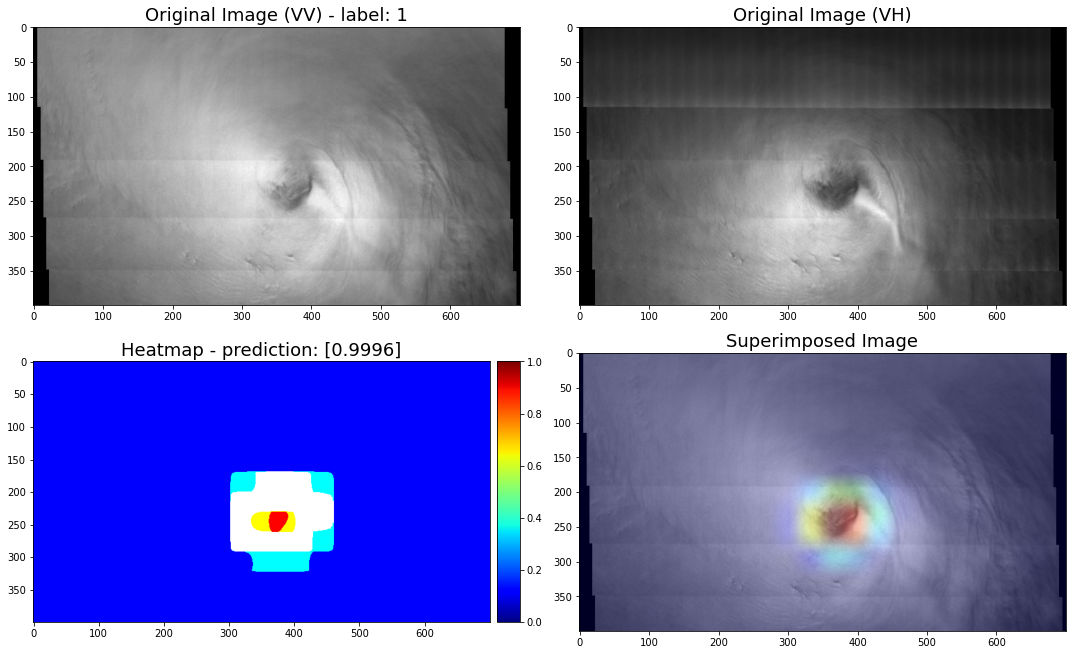

In [ ]:
MIN_HEIGHT = 700
MIN_WIDTH = 400
BATCH_SIZE = 1
NETWORK = "ResNet"
categorization = False

# Preprocess image
df = pd.read_csv(main_dir + "/csv/full_dataset.csv", converters={'bbox_shape': eval}).dropna()
if categorization:
  images, labels, bboxes = helper.load_from_df_with_cat(df[204:205])
else:
  images, labels, bboxes = helper.load_from_df(df[0:1])

# create an instance of the DataProcessor
processor = DataProcessor(model = NETWORK,
                          min_height = MIN_HEIGHT,
                          min_width = MIN_WIDTH)
count = -1
for image, bbox, label in zip(images, bboxes, labels):
  count += 1
  orig_image, processed_image = processor.preprocess_pipeline(image, bbox)
  processed_image = np.array([processed_image])

  # Print what the top predicted class is
  preds = model.predict(processed_image)
  #print("Predicted:", decode_predictions(preds, top=1)[0])
  predictions = np.round(preds[0],2) if categorization else preds[0]
  print("Prediction: {}, True label: {}".format(predictions, label))

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(
      processed_image, model, last_conv_layer_name, classifier_layer_names
  )

  # Display heatmap
  #plt.matshow(heatmap)
  #plt.show()
  #plt.imshow(orig_image[:,:,1])
  #plt.show()
  #plt.imshow(orig_image[:,:,2])
  #plt.show()
  ############################################
  ###  SUPERIMPOSED GARDCAM VISUALIZATION  ###
  ############################################
  # Load the original image
  #plt.imshow(orig_image)
  #plt.title("Original Image")
  #plt.show()
  #img = keras.preprocessing.image.load_img(image)
  #img = keras.preprocessing.image.img_to_array(img)

  # Rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((orig_image.shape[1], orig_image.shape[0]))
  jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  vv_channel = np.dstack((orig_image[:,:,2], orig_image[:,:,2], orig_image[:,:,2]))
  vh_channel = np.dstack((orig_image[:,:,1], orig_image[:,:,1], orig_image[:,:,1]))
  superimposed_img = jet_heatmap * 0.4 + vv_channel
  superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

  # Save the superimposed image
  #superimposed_img.save(save_path)

  # Display Grad CAM
  #display(Image(save_path))
  #plt.imshow(superimposed_img)
  #plt.title("Superimposed Image")
  #plt.show()

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15,9.2))
  font_size = 18
  ax1.imshow(vv_channel)    # plot vv channel
  ax1.set_title("Original Image (VV) - label: {}".format(label), fontsize = font_size)

  #ax2.imshow(np.squeeze(processed_image, axis=0))
  #ax2.set(title = "Normalised Image")
  ax2.imshow(vh_channel)  # plot vh channel
  ax2.set_title("Original Image (VH)", fontsize = font_size)

  #ax3.matshow(heatmap)
  #ax3.set(title = "Heatmap - prediction: {}".format(predictions))
  heat_plot = ax3.imshow(jet_heatmap, cmap='jet')
  ax3.set_title("Heatmap - prediction: {}".format(predictions), fontsize = font_size)
  divider = make_axes_locatable(ax3)
  cax = divider.append_axes("right", size="5%", pad=0.1)
  plt.colorbar(heat_plot, cax=cax)

  ax4.imshow(superimposed_img)
  ax4.set_title("Superimposed Image", fontsize = font_size)
  fig.tight_layout()
  plt.show()
  
  #fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (15,12))
  #ax1.imshow(vv_channel)  # plot vv channel
  #ax1.set(title = "Original Image (VV) - label: {}".format(label))

  #ax2.imshow(vh_channel)  # plot vh channel
  #ax2.set(title = "Original Image (VH)")

  #heat_plot = ax3.imshow(jet_heatmap, cmap='jet')
  #ax3.set(title = "Heatmap - prediction: {}".format(predictions))
  #divider = make_axes_locatable(ax3)
  #cax = divider.append_axes("right", size="5%", pad=0.1)
  #plt.colorbar(heat_plot, cax=cax)

  #ax4.imshow(superimposed_img)
  #ax4.set(title = "Superimposed Image")
  #fig.tight_layout()
  #plt.show()

  fig.savefig("{}/id_resnet_gradcam.jpg".format(save_path))
  #fig.savefig("{}/superimposed_{}.jpg".format(save_path, count))